## 跨境电商数据分析项目代码逻辑部分

In [1]:
import pandas as pd
import numpy as np 
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
from deep_translator import GoogleTranslator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
# 加载数据 (如果文件在当前目录，则无需写完整路径)
# amazon_df = pd.read_csv("Amazon Sale Report.csv") # 你原来的代码

# 解决方法：在读取CSV时，使用dtype参数指定第23列的数据类型为str
# 注意：列的索引是从0开始的，所以第23列的索引是22。你需要确认一下列名或者索引。
# 如果不确定是哪一列，可以将所有列都设置为str，即 dtype=str
try:
    amazon_df = pd.read_csv("Amazon Sale Report.csv", encoding='utf-8-sig', dtype={23: str})
except UnicodeDecodeError:
    amazon_df = pd.read_csv("Amazon Sale Report.csv", encoding='ISO-8859-1', dtype={23: str})


# 后面的代码保持不变
unesco_df = pd.read_csv("ich001.csv", encoding="utf-8-sig")

# 清理amazon数据
amazon_df.dropna(subset=["Amount", "Category", "Date"], inplace=True)
amazon_df["Date"] = pd.to_datetime(amazon_df["Date"], format="%m-%d-%y")
amazon_df["Amount"] = amazon_df["Amount"].astype(float)
amazon_df = amazon_df[amazon_df["Status"].isin(["Shipped", "Shipped - Delivered to Buyer"])]

# 输出检查
print("Amazon总计:", amazon_df.shape)
print("品类实例:", amazon_df["Category"].unique())
print("总销售额:", amazon_df["Amount"].sum())

# 清理UNESCO数据
unesco_df = unesco_df.dropna(subset=["Description EN", "Title EN"])
unesco_df["Inscription Year"] = unesco_df["Inscription Year"].astype(int)

print("UNESCO总计:", unesco_df.shape)
print("洽询国家:", unesco_df["Countries"].unique())

# 保存清洗后数据
amazon_df.to_csv("cleaned_amazon.csv", index=False)
unesco_df.to_csv("cleaned_unesco.csv", index=False)

Amazon总计: (106357, 24)
品类实例: ['kurta' 'Top' 'Set' 'Western Dress' 'Ethnic Dress' 'Bottom' 'Saree'
 'Blouse' 'Dupatta']
总销售额: 68975070.0
UNESCO总计: (788, 23)
洽询国家: ['BJ,NG,TG' 'BO' 'DO' 'EC,PE' 'GN' 'LT' 'MA' 'PH' 'ES' 'UZ' 'EE' 'MX' 'CN'
 'TO' 'VN' 'YE' 'CF' 'TR' 'RO' 'BR' 'CO' 'CR' 'IN' 'NI' 'KR' 'CN,MN'
 'MW,MZ,ZM' 'CZ' 'AL' 'BT' 'IT' 'PE' 'UA' 'CU' 'JP' 'OM' 'HR' 'ID' 'BS'
 'PY' 'SA' 'RS' 'KP' 'EG' 'DE' 'TN' 'GT' 'UA,EE' 'ZM' 'AZ'
 'BN,ID,MY,SG,TH' 'CM' 'CI' 'TM,IR' 'CU,DO,HT,HN,VE' 'EG,SA'
 'AF,AZ,IR,TR,TJ,TM,UZ' 'AD,FR' 'JM' 'AZ,KZ,KG,TJ,TR,TM,UZ' 'KZ' 'MY' 'NG'
 'NO' 'AF,AZ,IN,IR,IQ,KZ,KG,UZ,PK,TJ,TR,TM,MN' 'CN,MY' 'PT,ES' 'IR' 'ML'
 'MR' 'MN' 'AE' 'MD,RO' 'SN' 'BG' 'SG' 'CH' 'DK' 'TM' 'EC' 'AE,OM' 'BD'
 'AL,AD,AT,HR,FR,GR,IT,LU,RO,ES' 'AR' 'AT,BE,DE,IT,LU,NL,CH' 'AZ,TR' 'MG'
 'MT' 'ME' 'FI' 'CU,MX' 'FR,BE,LU,IT' 'PS' 'ID,MY' 'IR,TJ' 'PT'
 'SA,DZ,BH,EG,IQ,JO,KW,LB,MR,MA,OM,PS,SD,TN,AE,YE' 'LK' 'SY' 'TH' 'PL,BY'
 'VE' 'UG' 'DZ' 'BA' 'CL' 'GR' 'MK' 'KH' 'PK' 'AM' 'AT,CZ,DE,HU,SK'
 '

In [3]:
# 过滤相关非遗
keywords = ['craft', 'textile', 'embroidery', 'weaving', 'costume', 'dress', 'heritage product', 'handicraft']
relevant_unesco = unesco_df[unesco_df['Description EN'].str.contains('|'.join(keywords), case=False, na=False)]
print("相关非遗数量:", len(relevant_unesco))
relevant_unesco.to_csv('relevant_unesco.csv', index=False)

# 示例匹配：假设Amazon 'kurta'对应印度纺织非遗
non遗_products = amazon_df[amazon_df['Category'].str.contains('kurta|Set|Western Dress', case=False)]  # 调整关键词
print("潜在非遗产品订单:", len(non遗_products))

# 手动或自动映射：创建字典匹配UNESCO标题到Amazon Category
mapping = {
    'Oral heritage of Gelede': ['costume', 'mask'],  # 链接到Amazon 'Set' if relevant
    'Carnival of Oruro': ['embroidery', 'textile']
}
# 添加更多基于relevant_unesco['Title EN']

相关非遗数量: 346
潜在非遗产品订单: 95022


In [4]:
# 定义一个翻译函数，增加错误处理
def translate_text(text, target_lang):
    if not isinstance(text, str) or not text.strip():
        return ""
    try:
        return GoogleTranslator(source='auto', target=target_lang).translate(text)
    except Exception as e:
        print(f"翻译时出错: {e}")
        return text

# 选择目标语言并进行翻译 (以德语'de'和法语'fr'为例)
target_languages = ['de', 'fr']
unesco_translated_df = unesco_df.head(5).copy() # 注意：为防止API调用过多，仅对前5行进行演示

for lang in target_languages:
    column_name = f'Description_{lang.upper()}'
    print(f"正在翻译成 {column_name}...")
    unesco_translated_df[column_name] = unesco_translated_df['Description EN'].apply(lambda x: translate_text(x, lang))

print("\n翻译完成后的数据预览：")
display(unesco_translated_df)


正在翻译成 Description_DE...
正在翻译成 Description_FR...

翻译完成后的数据预览：


,UUID,ICH Public REF,Inscription Year,Title EN,Title FR,Description EN,Description FR,Type of element EN,Type of element FR,Type Acronym,...,Concepts Primary,Concepts primary names,Concepts secondary,Concept secondary names,World Heritage Sites,World Heritage,Images,Main image,Description_DE,Description_FR
0,632472e6-2b8b-4ed6-a398-bf21e2ee05f8,2,2008,Oral heritage of Gelede,Le patrimoine oral Gèlèdé,The Gelede is performed by the Yoruba-Nago com...,Le Gèlèdé est pratiqué par la communauté Yorub...,Representative List,Liste représentative,RL,...,"[{""name_en"": ""Costumes"", ""name_fr"": ""Costumes""...","Costumes,Masks,Oral tradition,Rituals","[{""name_en"": ""Animism"", ""name_fr"": ""Animisme"",...","Animism,Craft workers,Dance,Humour (literary),...","[{""ref"": ""1118"", ""name_en"": ""Osun-Osogbo Sacre...",True,"[{""photoID"": ""00371"", ""mandatoryID"": ""01"", ""or...",https://data.unesco.org/api/explore/v2.1/catal...,Der Gelede wird von der Yoruba-Nago-Community ...,La Gelede est réalisée par la communauté Yorub...
1,fc46100b-1765-426d-90c5-feaa43eef67c,3,2008,Carnival of Oruro,Le carnaval d’Oruro,"The town of Oruro, situated at an altitude of ...",Ancien site de cérémonies précolombien situé à...,Representative List,Liste représentative,RL,...,"[{""name_en"": ""Carnival"", ""name_fr"": ""Carnaval""...","Carnival,Procession,Religious practice","[{""name_en"": ""Colonial history"", ""name_fr"": ""H...","Colonial history,Costumes,Dance,Drama,Embroide...",NaN,False,"[{""photoID"": ""10741"", ""mandatoryID"": ""01"", ""or...",https://data.unesco.org/api/explore/v2.1/catal...,Die Stadt Oruro befand sich in einer Höhe von ...,"La ville d'Oruro, située à une altitude de 3 7..."
2,b9f51e7a-2ead-43af-8164-18d6388a4283,6,2008,Cultural space of the Brotherhood of the Holy ...,L’espace culturel de la Fraternité du Saint-Es...,The Brotherhood of the Holy Spirit of the Cong...,La Fraternité du Saint-Esprit des congos de Vi...,Representative List,Liste représentative,RL,...,"[{""name_en"": ""Cultural space"", ""name_fr"": ""Esp...","Cultural space,Percussion instruments,Religiou...","[{""name_en"": ""Colonial history"", ""name_fr"": ""H...","Colonial history,Dance,Feasts,Fraternity,Funer...",NaN,False,"[{""photoID"": ""00034"", ""mandatoryID"": ""01"", ""or...",https://data.unesco.org/api/explore/v2.1/catal...,Die Bruderschaft des Heiligen Geistes der Cong...,La confrérie du Saint-Esprit des congais de Vi...
3,b3cd474e-e25c-43e9-807c-bde04425a3e6,7,2008,Oral heritage and cultural manifestations of t...,Le patrimoine oral et les manifestations cultu...,The Zápara people live in a part of the Amazon...,Les Zápara vivent dans une partie de la jungle...,Representative List,Liste représentative,RL,...,"[{""name_en"": ""Cultural space"", ""name_fr"": ""Esp...","Cultural space,Oral tradition","[{""name_en"": ""Colonial history"", ""name_fr"": ""H...","Colonial history,Epidemics,Local languages,Myt...",NaN,False,"[{""photoID"": ""00551"", ""mandatoryID"": ""01"", ""or...",https://data.unesco.org/api/explore/v2.1/catal...,Die Zápara -Leute leben in einem Teil des Amaz...,Les gens de Zápara vivent dans une partie de l...
4,fec3abfb-8766-4410-a6ac-b2a90d2a9c3a,9,2008,Cultural space of Sosso-Bala,L’espace culturel du Sosso-Bala,"The sacred balafon instrument, known as the So...","Le balafon sacré, appelé Sosso-Bala, est consi...",Representative List,Liste représentative,RL,...,"[{""name_en"": ""Instrumental music"", ""name_fr"": ...","Instrumental music,Oral tradition,Percussion i...","[{""name_en"": ""Craft workers"", ""name_fr"": ""Arti...","Craft workers,Cultural space,Epic poetry,Festi...",NaN,False,"[{""photoID"": ""00041"", ""mandatoryID"": ""01"", ""or...",https://data.unesco.org/api/explore/v2.1/catal...,"Das heilige Balafon-Instrument, bekannt als So...","L'instrument sacré de Balafon, connu sous le n..."


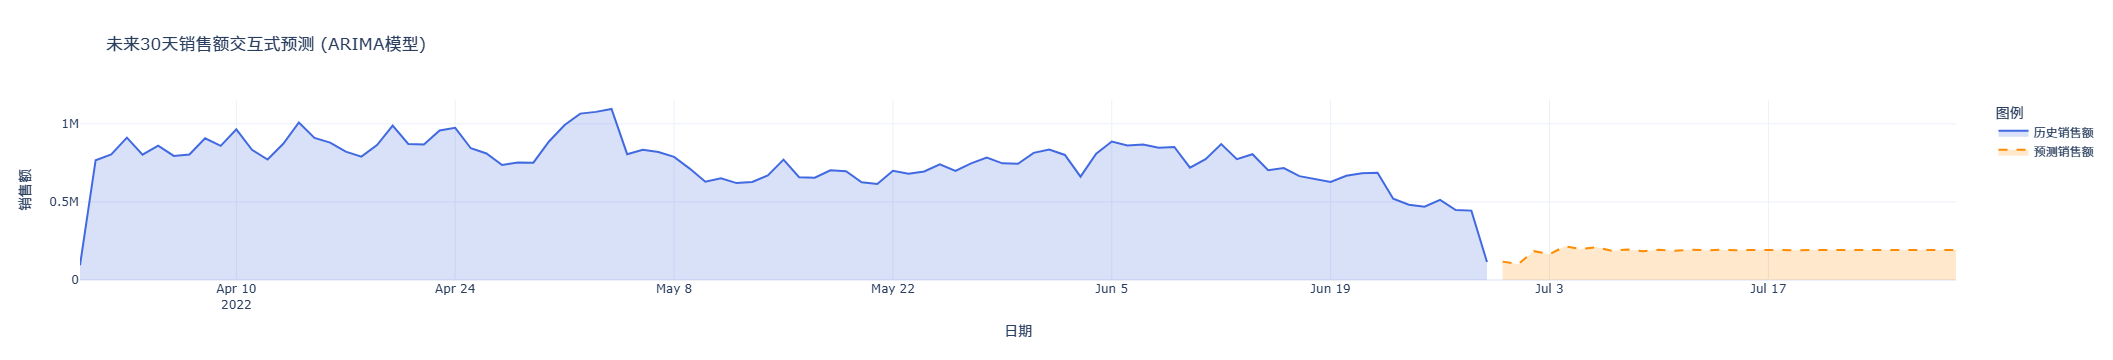

In [6]:
# 1. 准备时间序列数据
sales_ts = amazon_df.groupby('Date')['Amount'].sum().asfreq('D', fill_value=0)

# 2. ARIMA模型拟合与预测
model = ARIMA(sales_ts, order=(5, 1, 0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

# --- 使用 Plotly 创建交互式面积图 (此处为修改部分) ---
# 3. 创建 Plotly 图表对象
fig = go.Figure()

# 添加历史销售额的面积图
fig.add_trace(go.Scatter(
    x=sales_ts.index,
    y=sales_ts,
    mode='lines',  # 保持线条可见
    name='历史销售额',
    line=dict(color='royalblue', width=2),
    fill='tozeroy',  # <-- 新增: 将线下方的区域填充至Y=0轴
    fillcolor='rgba(65, 105, 225, 0.2)'  # <-- 新增: 设置一个半透明的填充颜色
))

# 添加预测销售额的面积图
fig.add_trace(go.Scatter(
    x=forecast.index,
    y=forecast,
    mode='lines',
    name='预测销售额',
    line=dict(color='darkorange', dash='dash', width=2),
    fill='tozeroy',  # <-- 新增: 填充区域
    fillcolor='rgba(255, 140, 0, 0.2)'  # <-- 新增: 设置半透明填充色
))

# 4. 更新图表布局 (与之前相同)
fig.update_layout(
    title='未来30天销售额交互式预测 (ARIMA模型)',
    xaxis_title='日期',
    yaxis_title='销售额',
    legend_title='图例',
    template='plotly_white'
)

# 5. 在 Jupyter 中显示交互式图表
fig.show()

In [8]:
# --- 步骤 1: 将数据从“交易粒度”聚合到“商品粒度” ---
# 我们按商品（这里用 'SKU' 作为唯一标识符，如果没有可以用 'Style'）进行分组
# 并计算每个商品的累计销售额、累计销量和被购买的次数
print("正在按商品聚合数据...")
product_agg_df = amazon_df.groupby('SKU').agg(
    total_amount=('Amount', 'sum'),      # 总销售额
    total_qty=('Qty', 'sum'),            # 总销量
    order_count=('Order ID', 'nunique')  # 订单数（多少个不同订单包含此商品）
).reset_index()

# 检查一下聚合后的数据
print("商品聚合数据预览：")
print(product_agg_df.head())


# --- 步骤 2: 特征选择和标准化 ---
# K-Means算法对数据的尺度很敏感（例如，销售额的数值远大于销量）
# 所以在聚类前必须进行标准化，让所有特征在同一尺度上
features_to_cluster = ['total_amount', 'total_qty', 'order_count']
features = product_agg_df[features_to_cluster]

# 初始化标准化器并对特征进行转换
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


# --- 步骤 3: 执行KMeans聚类 ---
# 对聚合后且标准化的商品数据进行聚类
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
product_agg_df.loc[:, 'cluster'] = kmeans.fit_predict(features_scaled)


# --- 步骤 4: 分析和解释聚类结果 ---
# 查看每个簇的特征均值（这是理解簇含义的关键）
# 我们用未标准化的原始数据来查看，这样结果更直观
cluster_summary = product_agg_df.groupby('cluster')[features_to_cluster].mean().sort_values(by='total_amount', ascending=False)
print("\n每个商品簇的特征均值:")
print(cluster_summary)

# 根据上面的均值，我们可以给簇打上标签，例如：
# total_amount 最高的那个簇就是我们的“热销商品”簇
hot_product_cluster_id = cluster_summary.index[0]
print(f"\n“热销商品”簇的ID是: {hot_product_cluster_id}")


# --- 步骤 5: 筛选出热销商品 ---
# 找出所有属于“热销商品”簇的商品，并按总销售额排序
hot_products = product_agg_df[product_agg_df['cluster'] == hot_product_cluster_id].sort_values(by='total_amount', ascending=False)

print("\n排名前10的热销商品:")
print(hot_products.head(10))

正在按商品聚合数据...
商品聚合数据预览：
              SKU  total_amount  total_qty  order_count
0     AN201-RED-M         458.0          2            2
1    AN201-RED-XL         602.0          2            2
2   AN201-RED-XXL         229.0          1            1
3  AN202-ORANGE-M         530.0          2            2
4  AN202-ORANGE-S        1141.0          4            4

每个商品簇的特征均值:
          total_amount   total_qty  order_count
cluster                                        
2        224516.533333  308.900000   307.566667
1         50892.408081   77.618182    77.315152
0          5663.940070    9.027519     8.998013

“热销商品”簇的ID是: 2

排名前10的热销商品:
                  SKU  total_amount  total_qty  order_count  cluster
1302      J0230-SKD-M      479750.0        432          430        2
4454     JNE3797-KR-L      434417.0        598          597        2
1303      J0230-SKD-S      422076.0        378          377        2
4455     JNE3797-KR-M      357995.0        489          484        2
4456     JNE37

In [11]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# ---  自动检测评论列的函数，优先检查常见列名 ---
def find_review_column(df):
    """自动在DataFrame中查找最可能是评论文本的列，优先检查常见列名。"""
    # 1. 优先检查精确匹配的常见评论列名
    priority_cols = ['reviews.text', 'review_text', 'content', 'comment', 'review']
    for p_col in priority_cols:
        if p_col in df.columns:
            # 确保该列至少有一些非空字符串，避免选到全是NaN的列
            if df[p_col].astype(str).str.strip().any():
                return p_col

    # 2. 如果精确匹配失败，查找包含关键词的列
    possible_cols = [col for col in df.columns if any(key in col.lower() for key in ['text', 'review', 'content', 'comment'])]
    if possible_cols:
        # 确保只对字符串列计算长度，避免非字符串类型报错
        string_cols = [col for col in possible_cols if df[col].dtype == 'object']
        if string_cols:
            # 规则：选择字符串平均长度最长的那个 (需先转为str，处理NaN)
            return max(string_cols, key=lambda col: df[col].astype(str).str.len().mean())
        
    # 3. 如果以上都失败，返回第一个数据类型为 'object' 的列
    object_cols = df.select_dtypes(include=['object']).columns
    if not object_cols.empty:
        # 选择第一个非空且非全是NaN的object列
        for col in object_cols:
            if df[col].astype(str).str.strip().any():
                return col
        
    # 如果以上都失败，返回 None
    return None

# --- (新功能) 从情感分数到星级的映射函数 ---
def sentiment_to_rating(sentiment):
    if sentiment >= 0.5: return 5
    elif sentiment >= 0.05: return 4
    elif sentiment > -0.05: return 3
    elif sentiment > -0.5: return 2
    else: return 1

# 1. 加载评论数据
try:
    reviews_df = pd.read_csv("reviews.csv")
    
    # --- (修改部分) 调用函数自动查找评论列名 ---
    review_column_name = find_review_column(reviews_df)

    if review_column_name is None:
        raise ValueError("在CSV文件中未能自动检测到任何文本评论列。请确保包含评论的列存在。")
        
    print(f"自动检测到评论列为: '{review_column_name}'")
    
    # 确保我们只使用检测到的文本列。先对该列进行强制字符串转换，处理 NaN
    reviews_df[review_column_name] = reviews_df[review_column_name].astype(str)
    # 删除转换后仍然是空白字符串的行（例如，原始是NaN或空字符串的）
    reviews_df.dropna(subset=[review_column_name], inplace=True)
    reviews_df = reviews_df[reviews_df[review_column_name].str.strip() != 'None'].copy() # 移除 'None' 字符串

    # 确保 rating 列也存在，如果不存在则会重新生成
    if 'rating' not in reviews_df.columns:
        # 如果原始文件不含 rating，则只保留评论文本
        reviews_df = reviews_df[[review_column_name]].copy()
        # VADER 分析后会自行生成 rating 列
    else:
        # 如果原始文件包含 rating，则保留这两列
        reviews_df = reviews_df[[review_column_name, 'rating']].copy()

except (FileNotFoundError, ValueError) as e:
    print(f"数据加载或列检测失败: {e}。将使用模拟数据进行演示。")
    # 模拟数据现在同时包含 'rating' 和 'reviews.text'，并确保 'reviews.text' 是字符串
    reviews_data = {
        'rating': [5, 5, 2, 1, 4, 3],
        'reviews.text': [ # 使用 'reviews.text' 列名
            'This is absolutely fantastic! Best purchase ever.',
            'I love it, works perfectly and looks great.',
            'It broke after two days. Very disappointed.',
            'Do not buy this product. A complete waste of money.',
            'It is pretty good for the price, but the battery could be better.',
            'It works, but the quality is not as expected.'
        ]
    }
    reviews_df = pd.DataFrame(reviews_data)
    review_column_name = 'reviews.text' # 模拟数据的评论列名


# 2. 初始化 VADER 分析器
analyzer = SentimentIntensityAnalyzer()

# 3. 执行情感分析
# 确保在 apply 之前 reviews_df[review_column_name] 已经是字符串类型
reviews_df['sentiment'] = reviews_df[review_column_name].apply(lambda text: analyzer.polarity_scores(text)['compound'])

# 4. 如果原始数据不含 'rating'，则从情感分数生成估算星级
if 'rating' not in reviews_df.columns:
    reviews_df['rating'] = reviews_df['sentiment'].apply(sentiment_to_rating)

# --- 后续代码保持不变 ---
print("\n【VADER分析】包含估算星级和情感分数的完整数据：")
display(reviews_df[['rating', review_column_name, 'sentiment']])

min_rating = 4
high_rating_reviews = reviews_df[reviews_df['rating'] >= min_rating].copy()
print(f"\n筛选出估算评分 >= {min_rating} 星的评论：")
display(high_rating_reviews)

max_rating = 2 
low_rating_reviews_filtered = reviews_df[reviews_df['rating'] <= max_rating].copy()
print(f"\n筛选出估算评分 <= {max_rating} 星的评论：")
display(low_rating_reviews_filtered)

avg_sentiment_high = high_rating_reviews['sentiment'].mean() if not high_rating_reviews.empty else 0
avg_sentiment_low = low_rating_reviews_filtered['sentiment'].mean() if not low_rating_reviews_filtered.empty else 0

print(f"\n高分 (估算>={min_rating}星) 评论的平均情感分: {avg_sentiment_high:.2f}")
print(f"低分 (估算<={max_rating}星) 评论的平均情感分: {avg_sentiment_low:.2f}")

自动检测到评论列为: 'reviews.text'

【VADER分析】包含估算星级和情感分数的完整数据：


,rating,reviews.text,sentiment
0,5,I initially had trouble deciding between the p...,0.9882
1,5,Allow me to preface this with a little history...,0.9886
2,4,I am enjoying it so far. Great for reading. Ha...,0.4364
3,5,I bought one of the first Paperwhites and have...,0.9755
4,5,I have to say upfront - I don't like coroporat...,0.9980
...,...,...,...
1592,1,This is not the same remote that I got for my ...,-0.7405
1593,1,I have had to change the batteries in this rem...,-0.9205
1594,1,"Remote did not activate, nor did it connect to...",-0.8126
1595,5,It does the job but is super over priced. I fe...,0.8271



筛选出估算评分 >= 4 星的评论：


,reviews.text,sentiment,rating
0,I initially had trouble deciding between the p...,0.9882,5
1,Allow me to preface this with a little history...,0.9886,5
2,I am enjoying it so far. Great for reading. Ha...,0.4364,4
3,I bought one of the first Paperwhites and have...,0.9755,5
4,I have to say upfront - I don't like coroporat...,0.9980,5
...,...,...,...
1588,Don't bother paying for one or getting a repla...,0.1777,4
1589,I've had the REPLACEMENT remote 3 months and i...,0.1531,4
1590,Voice remote gave out nearly a year after I pu...,0.6914,5
1591,Purchased my first one with the TV Fire box ov...,0.8119,5



筛选出估算评分 <= 2 星的评论：


,reviews.text,sentiment,rating
23,The Kindle is my first e-ink reader. I own an ...,-0.0580,2
33,The Kindle is my first e-ink reader. I own an ...,-0.0580,2
35,The Kindle is my first e-ink reader. I own an ...,-0.0580,2
39,All of them quit working. There's absolutely n...,-0.6881,1
44,I got my Kindle a few years ago and barely use...,-0.8516,1
...,...,...,...
1586,All in all I love this remote! It's pretty sma...,-0.8333,1
1592,This is not the same remote that I got for my ...,-0.7405,1
1593,I have had to change the batteries in this rem...,-0.9205,1
1594,"Remote did not activate, nor did it connect to...",-0.8126,1



高分 (估算>=4星) 评论的平均情感分: 0.84
低分 (估算<=2星) 评论的平均情感分: -0.50


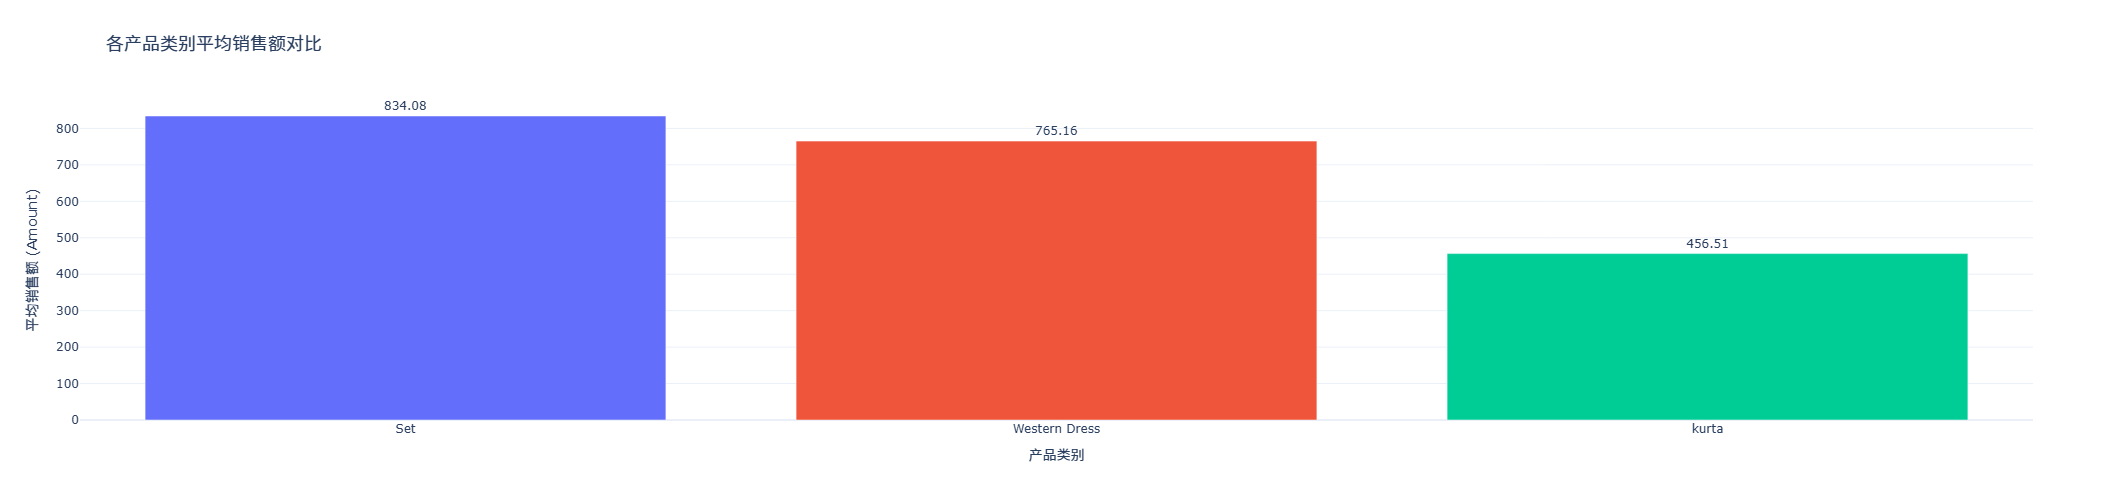

In [14]:
import plotly.graph_objects as go
import plotly.express as px
# 1. 准备数据 
category_means = non遗_products.groupby('Category')['Amount'].mean().sort_values(ascending=False).reset_index()

# 2. 使用 Plotly Express 创建图表 
fig = px.bar(
    category_means,
    x='Category',
    y='Amount',
    color='Category',
    text_auto='.2f',
    labels={'Category': '产品类别', 'Amount': '平均销售额 (Amount)'},
    title='各产品类别平均销售额对比'
)

# --- 调整布局以改变柱体宽高比 ---
# 3. 美化和定制图表布局
fig.update_layout(
    # 通过减小宽度和增加高度来让柱体显得更高更窄
    width=600,   # <-- 减小图表宽度
    height=500,  # <-- 可以适度增加图表高度
    
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    title_font_size=18,
    template='plotly_white',
    showlegend=False
)

# 4. 调整文本标签位置 (与之前相同)
fig.update_traces(
    textposition='outside',
    textfont_size=12
)

# 5. 在 Jupyter 中显示交互式图表
fig.show()